This fil is for CNN application

In [1]:
#pip install opencv-python

In [2]:
 #import libraries 
import sys
import os
# the pah to a repository containing tool_kit 
path_to_tool_kit = os.path.abspath('..')
if path_to_tool_kit not in sys.path:
    sys.path.append(path_to_tool_kit)
import tool_kit as tk
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [3]:
print(path_to_tool_kit)

e:\Cobalt\cobalt


In [4]:
tk.set_path_to_dataset('..')
images = tk.load_data_image()
mask = tk.load_data_mask()
print(' images =\n',images.head())
print(' mask =\n',mask .head())
# mask is a data frame of type pandas that coontains images id and the number of the cells in the image
# images is a data frame of type pandas that contains the images id , the  number of the cells in the imamage , the boolean of the mask and blur

 images =
                             image_id  nb_cells mask  blur
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1  yes     1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1  yes     1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1  yes     1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1  yes     1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1  yes     1
 mask =
                             image_id  nb_cells
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1


Select the data frame that you want to use 

In [ ]:
mask_or_image='mask'
if mask_or_image=='mask':
    df=mask
else:
    df=images.copy()
    df.drop(columns=['blur', 'mask'],inplace=True) 
df

,image_id,nb_cells
0,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1
1,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1
2,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1
3,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1
4,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1
...,...,...
1195,SIMCEPImages_A24_C100_F1_s23_w2.TIF,100
1196,SIMCEPImages_A24_C100_F1_s24_w1.TIF,100
1197,SIMCEPImages_A24_C100_F1_s24_w2.TIF,100
1198,SIMCEPImages_A24_C100_F1_s25_w1.TIF,100


## Separation test set et train set

In [6]:
frac=0.2
df_test= df.sample( frac=frac, replace=False, random_state=42)
df_train = df.drop(df_test.index)

print('len(df) =',len(df))
print('len(df_train) =',len(df_train))
print('len(df_test) =',len(df_test))
print( 'df_train =\n',df_train.head())
print( 'df_test =\n',df_test.head())    


len(df) = 1200
len(df_train) = 960
len(df_test) = 240
df_train =
                             image_id  nb_cells
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1
df_test =
                                  image_id  nb_cells
1178  SIMCEPImages_A24_C100_F1_s15_w1.TIF       100
865    SIMCEPImages_A18_C74_F1_s08_w2.TIF        74
101    SIMCEPImages_A03_C10_F1_s01_w2.TIF        10
439    SIMCEPImages_A09_C35_F1_s20_w2.TIF        35
58      SIMCEPImages_A02_C5_F1_s05_w1.TIF         5


## Test d'affichage d'images et de nombre de cellules dedans  


In [7]:
"""IMG_HEIGHT = 128*2
IMG_WIDTH = 128*2
df_train = tk.data_to_numpy(df=df_train,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)
df_test = tk.data_to_numpy(df=df_test,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)
df_train=df.to_numpy()
df_test=df.to_numpy()"""

'IMG_HEIGHT = 128*2\nIMG_WIDTH = 128*2\ndf_train = tk.data_to_numpy(df=df_train,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)\ndf_test = tk.data_to_numpy(df=df_test,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)\ndf_train=df.to_numpy()\ndf_test=df.to_numpy()'

In [8]:
df.shape

(1200, 2)

In [9]:
print( len(df_train))

960


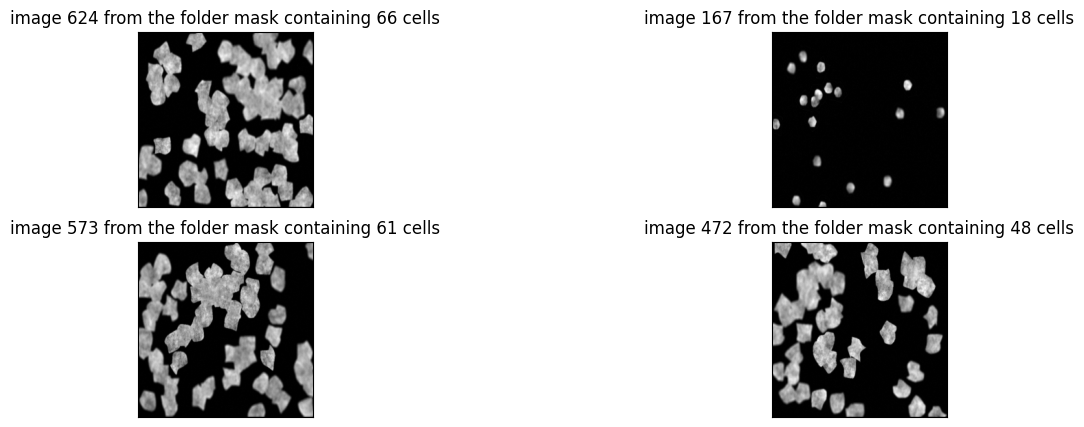

In [10]:

IMG_HEIGHT = 128*2
IMG_WIDTH = 128*2
Matrix=df_train
n_img_to_show = 4
fig = plt.figure(figsize=(15,5))
indices=list(range(len(Matrix)))
np.random.shuffle(indices)

for i in range(n_img_to_show):
    ax=fig.add_subplot(2, n_img_to_show//2 , i+1 , xticks=[], yticks=[])
    ax.imshow(np.squeeze(tk.get_image(img_id=Matrix['image_id'].iloc[indices[i]],img_height=IMG_HEIGHT, img_width=IMG_WIDTH, mask_or_image= mask_or_image)),cmap='gray')
    
    ax.set_title(f'image {indices[i]} from the folder {mask_or_image} containing {Matrix['nb_cells'].iloc[indices[i]]} cells')
plt.show()

## convertit les données pour pytorch

In [11]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
  indices= list( range(len(train_data)))
  np.random.shuffle(indices)
  split= int( np.floor(valid_size * len(train_data)))
  train_indexes, valid_indexes = indices[split:], indices[:split]
  valid_samplers= SubsetRandomSampler(valid_indexes)
  train_samplers= SubsetRandomSampler(train_indexes)
  valid_loader =torch.utils.data.DataLoader( train_data, batch_size = batch_size, sampler = valid_samplers)
  train_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler= train_samplers)
  return train_loader, valid_loader, test_loader


In [12]:
type(df_train)

pandas.core.frame.DataFrame

In [13]:
#costumiz the format of the path 


In [14]:
from costumize_data import CustomDataset 
trasform= transforms.Compose([transforms.ToTensor()])
train_data= CustomDataset(df_train,transform=trasform)
train_data.set_path_to_dataset('..')
test_data= CustomDataset(df_test,transform=trasform)
test_data.set_path_to_dataset('..')
train_loader, valid_loader, test_loader =create_data_loaders(batch_size, valid_size, train_data, test_data)

In [15]:
print( train_data.__getitem__(800)[0][0][0][0])

tensor(0.0353)


## Image et mask correspondant généré avec u-net

In [37]:
import torch.nn as nn
import torch.nn.functional as F

dropout = 0.2
nb_filtre = 4

p = 1 #for padding 
k=3 # for kernel size
s=1 # for stride
pool_k=2
pool_s=2
class CNN(nn.Module):

    def __init__(self, img_height, img_width):
        super(CNN,self).__init__()
       
        self.im_height = img_height
        self.im_width = img_width
        self.size= img_height * img_width
        self.conv1=self.conv_block(in_channels= 1, out_channels=nb_filtre)
        self.conv2=self.conv_block(in_channels= nb_filtre*(2**0) , out_channels=nb_filtre*(2**1))
        self.conv3=self.conv_block(in_channels= nb_filtre*(2**1), out_channels=nb_filtre*(2**2))
        self.conv4=self.conv_block(in_channels=nb_filtre*(2**2) , out_channels=nb_filtre*(2**3))
        self.pool= nn.MaxPool2d(kernel_size=pool_k, stride=pool_s)
        self.calculate_output_dims()
        self.dense1=self.dense_layer(size=self.size)
        self.size= self.size//(2**2)
        self.dense2=self.dense_layer(size=self.size)
        self.size= self.size//(2**2)
        self.fc= nn.Linear(self.size, 1)
    def calculate_output_dims(self):
        # Recalculate height and width after each pooling layer (4 poolings)
        for _ in range(4):
            self.im_height = (self.im_height + 2 * p - k) // s + 1  # After each conv
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            self.im_height = (self.im_height + 2 * p - k) // s + 1  # After each conv
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            
            
            self.im_height = self.im_height // pool_k  # After pooling
            self.im_width = self.im_width // pool_k
        
        # Flattened size for dense layers
        self.size = self.im_height * self.im_width * nb_filtre * (2**4)  # Matches last conv output channels

    
    def forward(self,x):
        out=self.conv1(x)
        out=self.pool(out)
        out=self.conv2(out)
        out=self.pool(out)
        out=self.conv3(out)
        out=self.pool(out)
        out=self.conv4(out)
        out=self.pool(out)
        out=out.view(-1,out.size(0))
        out=self.dense1(out)
        out=self.dense2(out)
        out=self.fc(out)
        return out
    
    def dense_layer(self,size ):
        block = nn.Sequential(
            nn.Linear(size,size //(2**1)),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(size//(2**1), size//(2**2)),
            nn.ReLU(inplace=True)
        )
        return block
    def conv_block(self, in_channels, out_channels):
        """
        Block de convolution : Conv2d -> ReLU -> Dropout -> Conv2d -> ReLU -> Dropout
        """
        
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=p),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),  # Dropout après chaque couche de convolution
            nn.Conv2d(out_channels, out_channels, kernel_size=k, padding=p),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        return block

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [38]:
CNN = CNN(img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
CNN.to(device=device)


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stri

In [39]:
from torchsummary import summary
summary(model=CNN, input_size=(1, IMG_HEIGHT, IMG_WIDTH))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8192x2 and 16384x8192)